## Boston Crime Forecasting (2015-2018)
### Anil Abraham 2023

#### The goal of this project is to use machine learning techniques to forecast crime in Boston. Particularly, forecasting type of crime, number of crimes committed in a year, and crime hotspots.

### Brief explanation of each column:
<ul>
<li>INCIDENT_NUMBER - File number</li>
<li>OFFENSE_CODE - Code of specific crime</li>
<li>OFFENSE_CODE_GROUP - Name of crime</li>
<li>OFFENSE_DESCRIPTION - Detailed information about crime</li>
<li>DISTRICT - Boston neighbourhood</li>
<li>REPORTING_AREA - Area defined by Boston PD</li>
<li>SHOOTING - 'Y' represents a shooting occurence</li>
<li>OCCURRED_ON_DATE/YEAR/MONTH/DAY_OF_WEEK/HOUR - Date of crime</li>
<li>UCR_PART - Severity of the crime (highest is 1)</li>
<li>STREET/Lat/Long/Location - Location</li>
</ul>

### Importing libraries

In [18]:
import pandas as pd #Pandas for data manipulation and analysis
import numpy as np #Numpy for matrices
import geopandas as gpd #Support for geospatial data
from shapely.geometry import Point, Polygon #Geographic information systems functions and analysis
import matplotlib.pyplot as plt #Matplotlib for visualisations
import seaborn as sns
import plotly.express as px
#pd.set_option('display.max_rows', None)

### Data preprocessing

In [19]:
df = pd.read_csv('crime.csv', encoding='latin') #Thousands are seperated by commas in the CSV.

print(f'Null values found\n{df.isna().sum()}') #Check for null values

print(f'\n\n{df.columns}') #List all feature names

Null values found
INCIDENT_NUMBER             0
OFFENSE_CODE                0
OFFENSE_CODE_GROUP          0
OFFENSE_DESCRIPTION         0
DISTRICT                 1765
REPORTING_AREA              0
SHOOTING               318054
OCCURRED_ON_DATE            0
YEAR                        0
MONTH                       0
DAY_OF_WEEK                 0
HOUR                        0
UCR_PART                   90
STREET                  10871
Lat                     19999
Long                    19999
Location                    0
dtype: int64


Index(['INCIDENT_NUMBER', 'OFFENSE_CODE', 'OFFENSE_CODE_GROUP',
       'OFFENSE_DESCRIPTION', 'DISTRICT', 'REPORTING_AREA', 'SHOOTING',
       'OCCURRED_ON_DATE', 'YEAR', 'MONTH', 'DAY_OF_WEEK', 'HOUR', 'UCR_PART',
       'STREET', 'Lat', 'Long', 'Location'],
      dtype='object')


#### Check for duplicate INCIDENT_NUMBER

In [20]:
df[df['INCIDENT_NUMBER'] == 'I152030570-00']

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
318742,I152030570-00,3125,Warrant Arrests,WARRANT ARREST,E13,303,NaN,2016-10-29 08:25:00,2016,10,Saturday,8,Part Three,W WALNUT PARK,42.317207,-71.098799,"(42.31720702, -71.09879922)"
318743,I152030570-00,403,Aggravated Assault,ASSAULT & BATTERY D/W - OTHER,E13,303,NaN,2016-10-29 08:25:00,2016,10,Saturday,8,Part One,W WALNUT PARK,42.317207,-71.098799,"(42.31720702, -71.09879922)"
318744,I152030570-00,404,Aggravated Assault,"A&B HANDS, FEET, ETC. - MED. ATTENTION REQ.",E13,303,NaN,2016-10-29 08:25:00,2016,10,Saturday,8,Part One,W WALNUT PARK,42.317207,-71.098799,"(42.31720702, -71.09879922)"
318745,I152030570-00,3125,Warrant Arrests,WARRANT ARREST,E13,303,NaN,2016-10-29 08:25:00,2016,10,Saturday,8,Part Three,W WALNUT PARK,42.317207,-71.098799,"(42.31720702, -71.09879922)"


#### Fill null values

In [21]:
df['SHOOTING'].fillna('N', inplace=True) #Null shootings should be replaced with 'N'

df.loc[df['Lat'] == -1, ('Lat')] = None
df.loc[df['Long'] == -1, ('Long')] = None

#### Change categories

In [22]:
df['OCCURRED_ON_DATE'] = pd.to_datetime(df['OCCURRED_ON_DATE']) #Convert this column to pandas datatype 'datetime'
df['DAY_OF_WEEK'] = pd.Categorical(df['DAY_OF_WEEK'],  #Convert to category to save memory
              categories=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],
              ordered=True)

#### What are the datatypes used?

In [23]:
df.dtypes

INCIDENT_NUMBER                object
OFFENSE_CODE                    int64
OFFENSE_CODE_GROUP             object
OFFENSE_DESCRIPTION            object
DISTRICT                       object
REPORTING_AREA                 object
SHOOTING                       object
OCCURRED_ON_DATE       datetime64[ns]
YEAR                            int64
MONTH                           int64
DAY_OF_WEEK                  category
HOUR                            int64
UCR_PART                       object
STREET                         object
Lat                           float64
Long                          float64
Location                       object
dtype: object

#### What does the csv file look like?

In [24]:
df.head(6)

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
0,I182070945,619,Larceny,LARCENY ALL OTHERS,D14,808,N,2018-09-02 13:00:00,2018,9,Sunday,13,Part One,LINCOLN ST,42.357791,-71.139371,"(42.35779134, -71.13937053)"
1,I182070943,1402,Vandalism,VANDALISM,C11,347,N,2018-08-21 00:00:00,2018,8,Tuesday,0,Part Two,HECLA ST,42.306821,-71.060300,"(42.30682138, -71.06030035)"
2,I182070941,3410,Towed,TOWED MOTOR VEHICLE,D4,151,N,2018-09-03 19:27:00,2018,9,Monday,19,Part Three,CAZENOVE ST,42.346589,-71.072429,"(42.34658879, -71.07242943)"
3,I182070940,3114,Investigate Property,INVESTIGATE PROPERTY,D4,272,N,2018-09-03 21:16:00,2018,9,Monday,21,Part Three,NEWCOMB ST,42.334182,-71.078664,"(42.33418175, -71.07866441)"
4,I182070938,3114,Investigate Property,INVESTIGATE PROPERTY,B3,421,N,2018-09-03 21:05:00,2018,9,Monday,21,Part Three,DELHI ST,42.275365,-71.090361,"(42.27536542, -71.09036101)"
5,I182070936,3820,Motor Vehicle Accident Response,M/V ACCIDENT INVOLVING PEDESTRIAN - INJURY,C11,398,N,2018-09-03 21:09:00,2018,9,Monday,21,Part Three,TALBOT AVE,42.290196,-71.071590,"(42.29019621, -71.07159012)"


#### Let's explore the crime type

In [25]:
for i, g in df.groupby(['UCR_PART'], observed=True)['OFFENSE_CODE_GROUP'].unique().items():
    print(i, "\n", g, '\n')

Other 
 ['Arson' 'License Plate Related Incidents' 'Auto Theft Recovery' 'Other'
 'Manslaughter' 'Burglary - No Property Taken'] 

Part One 
 ['Larceny' 'Auto Theft' 'Robbery' 'Larceny From Motor Vehicle'
 'Residential Burglary' 'Aggravated Assault' 'Other Burglary'
 'Commercial Burglary' 'Homicide'] 

Part Three 
 ['Towed' 'Investigate Property' 'Motor Vehicle Accident Response'
 'Verbal Disputes' 'Fire Related Reports' 'Property Lost'
 'Medical Assistance' 'Assembly or Gathering Violations' 'Property Found'
 'Police Service Incidents' 'Warrant Arrests' 'Other'
 'Property Related Damage' 'Missing Person Reported' 'Investigate Person'
 'License Plate Related Incidents' 'Harbor Related Incidents'
 'Firearm Discovery' 'Landlord/Tenant Disputes' 'Missing Person Located'
 'Service' 'Search Warrants' 'License Violation' 'Explosives' 'Aircraft'
 'Prisoner Related Incidents'] 

Part Two 
 ['Vandalism' 'Other' 'Simple Assault' 'Restraining Order Violations'
 'Violations' 'Harassment' 'Ballisti

#### Every crime has been binned into a UCR_PART, indicating its severity. There are NaN values though in this column. Let's take a look at the crimes where the severity is NaN.

In [26]:
df.loc[np.where(df['UCR_PART'].isna())]['OFFENSE_CODE_GROUP'].value_counts()

HOME INVASION                                77
HUMAN TRAFFICKING                             7
INVESTIGATE PERSON                            4
HUMAN TRAFFICKING - INVOLUNTARY SERVITUDE     2
Name: OFFENSE_CODE_GROUP, dtype: int64

#### The above 4 crimes do not have a severity rating. Categorise it as 'other'

In [27]:
df.loc[df['UCR_PART'].isna(), ('UCR_PART')] = 'Other'

### Exploratory Data Analysis

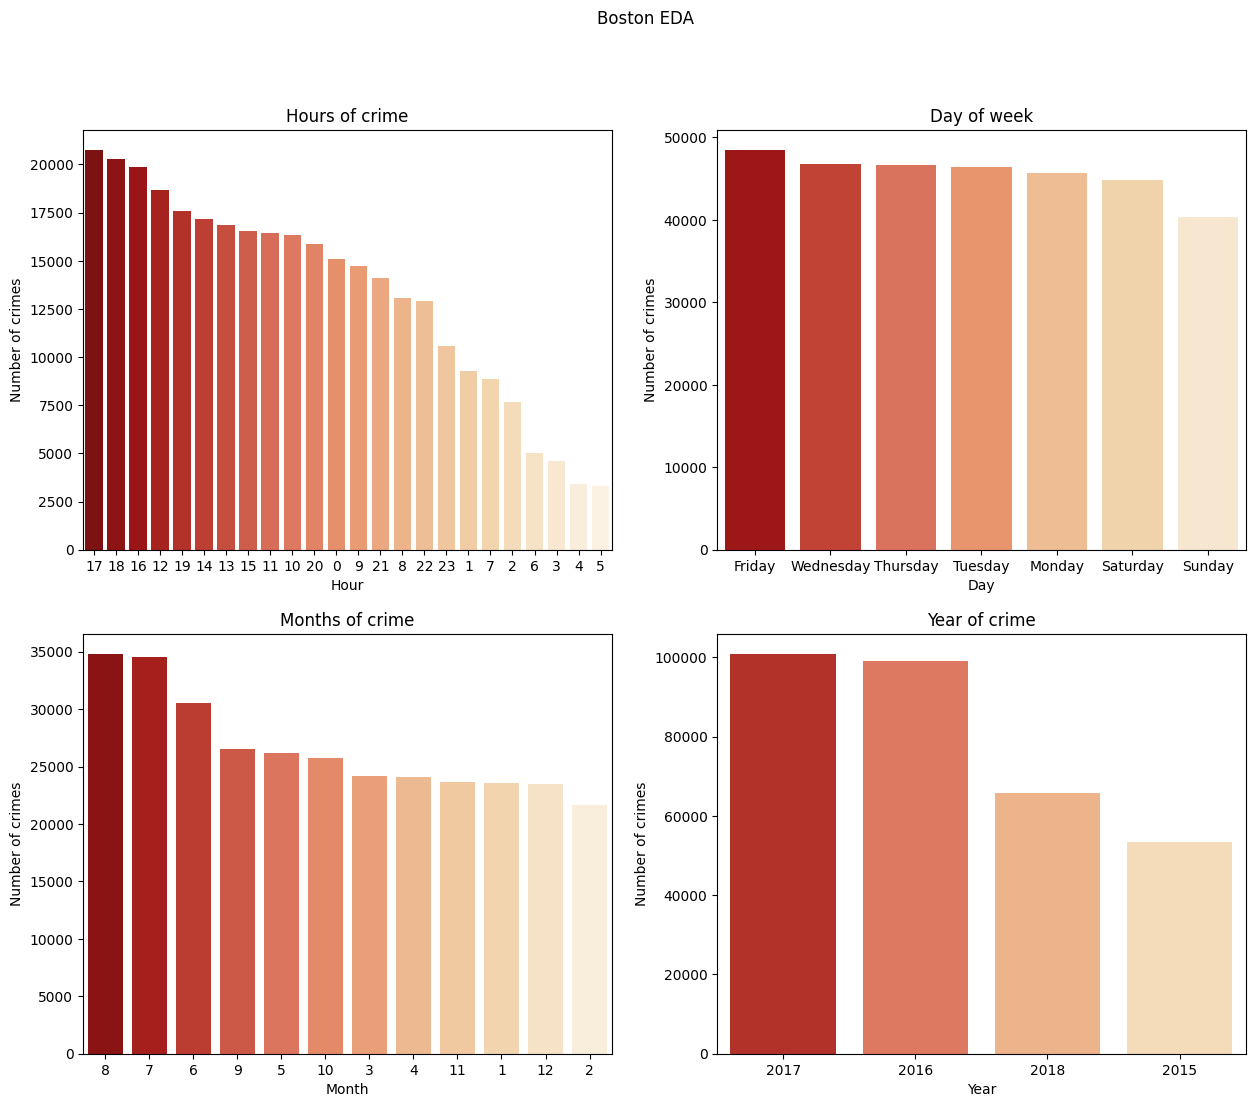

In [28]:
df_hours = df.groupby(['HOUR'], observed=True).count()['INCIDENT_NUMBER'].sort_values(ascending=False)
df_week = df.groupby(['DAY_OF_WEEK'], observed=True).count()['INCIDENT_NUMBER'].sort_values(ascending=False)
df_month = df.groupby(['MONTH'], observed=True).count()['INCIDENT_NUMBER'].sort_values(ascending=False)
df_year = df.groupby(['YEAR'], observed=True).count()['INCIDENT_NUMBER'].sort_values(ascending=False)

fig, axs = plt.subplots(2, 2, figsize=(15, 12))

sns.barplot(x=df_hours.index, y=df_hours.values, order=df_hours.index, palette="OrRd_r", ax = axs[0,0])
sns.barplot(x=df_week.index, y=df_week.values, order=df_week.index, palette="OrRd_r", ax = axs[0,1])
sns.barplot(x=df_month.index, y=df_month.values, order=df_month.index, palette="OrRd_r", ax = axs[1,0])
sns.barplot(x=df_year.index, y=df_year.values, order=df_year.index, palette="OrRd_r", ax = axs[1,1])

axs[0,0].set_title('Hours of crime')
axs[0,0].set_xlabel('Hour')
axs[0,0].set_ylabel('Number of crimes')

axs[0,1].set_title('Day of week')
axs[0,1].set_xlabel('Day')
axs[0,1].set_ylabel('Number of crimes')

axs[1,0].set_title('Months of crime')
axs[1,0].set_xlabel('Month')
axs[1,0].set_ylabel('Number of crimes')

axs[1,1].set_title('Year of crime')
axs[1,1].set_xlabel('Year')
axs[1,1].set_ylabel('Number of crimes')

fig.suptitle('Boston EDA')
plt.show()

As the above EDA suggests, most crimes in Boston from 2015-2018 took place between 4pm-6pm. Furthermore, most crimes took place on Fridays. The data suggests that most crimes in Boston take place in August and July, and that the years 2018 and 2015 saw a reduction in crime. This cannot be assumed to be true though, as this Boston crime dataset recorded data from June 2015 to September 2018, meaning we have a full years worth of data for 2017 and 2016 and half a years worth of data for 2018 and 2015.

#### Analysis of crimes

Text(0, 0.5, 'COUNT')

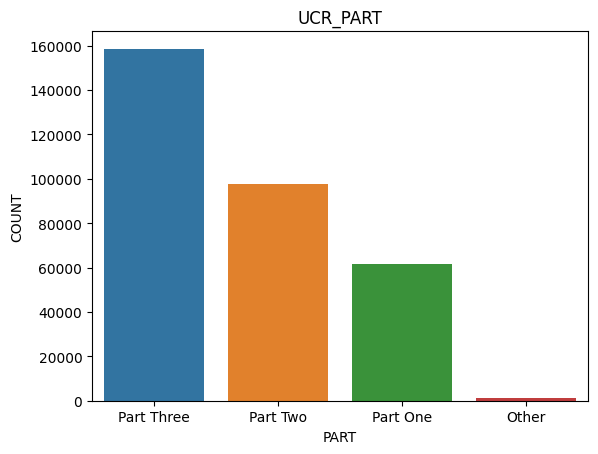

In [29]:
df_crimes = df.groupby(['UCR_PART'], observed=True).count()['INCIDENT_NUMBER'].sort_values(ascending=False)
sns.barplot(x=df_crimes.index, y=df_crimes.values, order=df_crimes.index)
plt.title('UCR_PART')
plt.xlabel('PART')
plt.ylabel('COUNT')

In [30]:
fig = px.scatter_mapbox(df.sample(frac=0.0001), lat="Lat", lon="Long",
                        color="UCR_PART", zoom=8, height=600, size_max=30)
fig.update_layout(mapbox_style="carto-darkmatter", margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [31]:
df[df['UCR_PART'] == 'Part One'].shape

(61629, 17)

In [56]:
df_time = df.groupby(df['OCCURRED_ON_DATE'].dt.month)['INCIDENT_NUMBER'].count()
df_time
# fig = plt.figure(figsize=(10,8))
# sns.lineplot(df_time.sample(frac=0.2), x='index', y='count')
# plt.tight_layout()
# plt.title('Time series of crimes')
# plt.xlabel('Date')
# plt.ylabel('Crime count')
# plt.show()

OCCURRED_ON_DATE
1     23610
2     21653
3     24146
4     24086
5     26199
6     30568
7     34556
8     34823
9     26543
10    25737
11    23675
12    23477
Name: INCIDENT_NUMBER, dtype: int64